In [12]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import least_squares, minimize
from scipy.special import logsumexp

In [13]:
def find_nearest(array,value):
    idx = (np.abs(array-value)).argmin()
    return idx

def find_line(xdata, ydata):
    A = np.vstack([xdata, np.ones(len(xdata))]).T
    return np.linalg.lstsq(A, np.log(ydata))[0]

with open('f_dt_2.txt') as f:
    lines = f.readlines()
    xx = np.array([float(line.split()[0]) for line in lines])
    yy = np.array([float(line.split()[1]) for line in lines])

x = 10**(xx/1000.0-10.0)
y = 1.0-np.cumsum(yy)/np.sum(yy)

mask = y>0
x=x[mask]
y=y[mask]

tstart=x[0]
tfinal=x[-1]

#Fit line in log-linear coordinates
x_subset=x[find_nearest(x, 0.05*x[-1]):find_nearest(x, 0.65*x[-1])]
y_subset=y[find_nearest(x, 0.05*x[-1]):find_nearest(x, 0.65*x[-1])]
m, c = find_line(x_subset, y_subset)
yline=np.exp(m*x+c)
gn=np.exp(c)
taun=-1/m

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  import sys


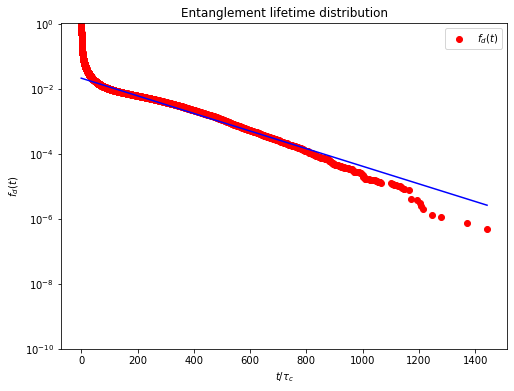

In [14]:
fig = plt.figure(figsize=(8, 6))

ax1 = fig.add_subplot(111)

ax1.set_title("Entanglement lifetime distribution")
ax1.set_xlabel(r'$t/\tau_c$')
ax1.set_ylabel(r'$f_d(t)$')

ax1.scatter(x,y, c='r', label=r'$f_d(t)$')
ax1.plot(x,yline, c='b')
plt.ylim(ymin=1e-10)
leg = ax1.legend()
#ax1.set_xscale('log')
ax1.set_yscale('log')

plt.show()

In [15]:
cutoff=find_nearest(x, 1e-2)
x=x[cutoff:]
y=y[cutoff:]
#Subsample data
x=x[0::10]
y=y[0::10]

In [16]:
def fdt(time, params):
    lambdaArr = np.split(params,2)[0]
    gArr = np.split(params,2)[1]/np.sum(np.split(params,2)[1])
    return np.dot(np.exp(-time/lambdaArr), gArr)

def log_fdt(time,params):
    lambdaArr = np.split(params,2)[0]
    gArr = np.split(params,2)[1]/np.sum(np.split(params,2)[1])
    return logsumexp(-time/lambdaArr, b=gArr)

#Vectorize function fdt and log_fdt
fdtvec=np.vectorize(fdt, excluded=['params'])
logfdtvec=np.vectorize(log_fdt, excluded=['params'])

#Define residuals
def residuals_fdt(param):
    return fdtvec(time=x, params=param)-y

def residuals_log_fdt(param):
    #print(logfdtvec(time=x[:-1], params=param)-np.log(y[:-1]))
    if np.any(fdtvec(time=x[:-1], params=param) < 0):
        return np.full(x[:-1].shape,1e8) #Penalty for negative f_d(t)
    else:
        return logfdtvec(time=x[:-1], params=param)-np.log(y[:-1])

def MSE(param):
    return np.dot(residuals_fdt(param),residuals_fdt(param))/np.size(x)

def log_MSE(param):
    return np.dot(residuals_log_fdt(param),residuals_log_fdt(param))/np.size(x)

In [17]:
fits_1 = [] #output of fitting function for all tested numbers of modes
successful_fits_1 = [] #number of modes for successful fits
for nmodes in range(2, 10):
    lambdaArrInit=10.0**((np.array(range(nmodes), float) + 1.0)/nmodes*np.log10(taun))
    #gArrInit=np.full(nmodes, 1.0/nmodes)
    gArrInit = np.append(np.full(nmodes-1, (1.0-gn)/(nmodes-1)),gn)

    print('nmodes\t{0}'.format(nmodes))
    fit = least_squares(residuals_fdt, np.append(lambdaArrInit, gArrInit), xtol=1e-15)
    fits_1.append(fit)

    if fit.success:
        weights = np.split(fit.x, 2)[1]/np.sum(np.split(fit.x, 2)[1])
        if not np.any(fdtvec(time=x, params=fit.x) < 0) and not np.any(weights<0):
            successful_fits_1.append(nmodes)
        print(fit.message)
        print('Initial guess MSE\t{0}'.format(MSE(np.append(lambdaArrInit, gArrInit))))
        print('Fit MSE\t\t\t{0}'.format(MSE(fit.x)))


nmodes	2
`gtol` termination condition is satisfied.
Initial guess MSE	0.08999166160707665
Fit MSE			0.00032768306951357437
nmodes	3
`gtol` termination condition is satisfied.
Initial guess MSE	0.08121790622551302
Fit MSE			0.00031560160202438357
nmodes	4
`ftol` termination condition is satisfied.
Initial guess MSE	0.07822229554161206
Fit MSE			0.00031551735030901554
nmodes	5
nmodes	6
`ftol` termination condition is satisfied.
Initial guess MSE	0.07577771665636317
Fit MSE			0.00029714028819876226
nmodes	7
`ftol` termination condition is satisfied.
Initial guess MSE	0.0751603425588343
Fit MSE			0.00030018739727411437
nmodes	8
`ftol` termination condition is satisfied.
Initial guess MSE	0.07471813380751366
Fit MSE			0.0002942355582513866
nmodes	9
`ftol` termination condition is satisfied.
Initial guess MSE	0.074385911948826
Fit MSE			0.00029296698656002353


In [18]:
fits_2 = [] #output of fitting function for all tested numbers of modes
min_log_SME = log_MSE(fits_1[successful_fits_1[0]-1].x)
best_nmodes = successful_fits_1[0]
for i in successful_fits_1:
    fit = fits_1[i-2]
    print('nmodes\t{0}'.format(i))

    fit2 = least_squares(residuals_log_fdt, fit.x, xtol=1e-14, ftol=1e-14)
    fits_2.append(fit2)

    if fit2.success:
        weights = np.split(fit2.x, 2)[1]/np.sum(np.split(fit2.x, 2)[1])
        if log_MSE(fit2.x)<min_log_SME and not np.any(weights<0):
            min_log_SME = log_MSE(fit2.x)
            best_fit = fit2
            best_nmodes = i
        print(fit2.message)
        print('Weights\t{0}'.format(weights))
        print('First fit log-MSE\t{0}'.format(log_MSE(fit.x)))
        print('Second fit log-MSE\t{0}'.format(log_MSE(fit2.x)))

    print(' ')

nmodes	2
`ftol` termination condition is satisfied.
Weights	[0.96847987 0.03152013]
First fit log-MSE	71.81777542963358
Second fit log-MSE	0.07357364396564177
 
nmodes	3
`ftol` termination condition is satisfied.
Weights	[0.86060909 0.11729577 0.02209514]
First fit log-MSE	0.06478521437970414
Second fit log-MSE	0.010845310095296727
 


In [19]:
best_nmodes

3

In [20]:
best_fit.x

array([  1.17195164,  10.51046713, 154.75348747, 121.69273973,
        16.58597766,   3.12431986])

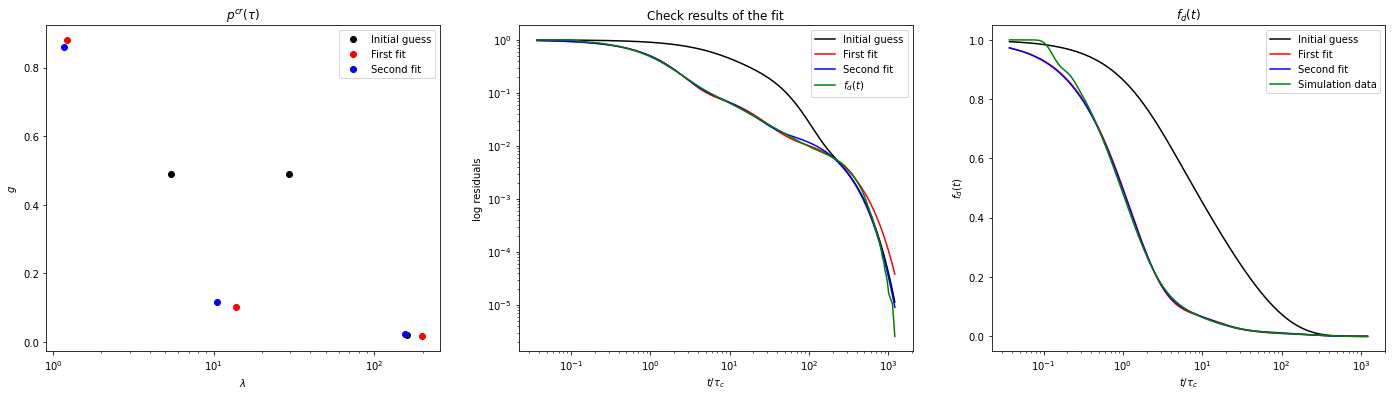

In [21]:
fit = fits_1[best_nmodes-2]
fit2 = best_fit

fig3 = plt.figure(figsize=(24, 6))

ax0 = fig3.add_subplot(131)

ax0.set_title(r'$p^{cr}\left(\tau\right)$')
ax0.set_xlabel(r'$\lambda$')
ax0.set_ylabel(r'$g$')

ax0.scatter(10.0**((np.array(range(best_nmodes), float) + 1.0)/best_nmodes*np.log10(taun)),np.append(np.full(best_nmodes-1, (1.0-gn)/(best_nmodes-1)),gn), c='k', label=r'Initial guess')
ax0.scatter(np.split(fit.x,2)[0], np.split(fit.x,2)[1]/np.sum(np.split(fit.x,2)[1]), c='r', label=r'First fit')
ax0.scatter(np.split(fit2.x,2)[0],np.split(fit2.x,2)[1]/np.sum(np.split(fit2.x,2)[1]), c='b', label=r'Second fit')
leg = ax0.legend()
ax0.set_xscale('log')

ax1 = fig3.add_subplot(132)

ax1.set_title("Check results of the fit")
ax1.set_xlabel(r'$t/\tau_c$')
ax1.set_ylabel(r'log residuals')

ax1.plot(x,fdtvec(time=x, params=np.append(10.0**((np.array(range(best_nmodes), float) + 1.0)/best_nmodes*np.log10(taun)),np.append(np.full(best_nmodes-1, (1.0-gn)/(best_nmodes-1)),gn))), c='k', label=r'Initial guess')
ax1.plot(x,fdtvec(time=x, params=fit.x), c='r', label=r'First fit')
ax1.plot(x,fdtvec(time=x, params=fit2.x), c='b', label=r'Second fit')
ax1.plot(x,y, c='g', label=r'$f_d(t)$')

leg = ax1.legend()
ax1.set_xscale('log')
ax1.set_yscale('log')

ax2 = fig3.add_subplot(133)

ax2.set_title(r'$f_d(t)$')
ax2.set_xlabel(r'$t/\tau_c$')
ax2.set_ylabel(r'$f_d(t)$')

ax2.plot(x,fdtvec(time=x, params=np.append(lambdaArrInit, gArrInit)), c='k', label=r'Initial guess')
ax2.plot(x,fdtvec(time=x, params=fit.x), c='r', label=r'First fit')
ax2.plot(x,fdtvec(time=x, params=fit2.x), c='b', label=r'Second fit')
ax2.plot(x,y, c='g', label=r'Simulation data')
leg = ax2.legend()
ax2.set_xscale('log')

plt.show()

In [22]:
li=np.split(fit2.x,2)[0]
gi=np.multiply(np.split(fit2.x,2)[0], np.split(fit2.x,2)[1]/np.sum(np.split(fit2.x,2)[1]))/np.dot(np.split(fit2.x,2)[0], np.split(fit2.x,2)[1]/np.sum(np.split(fit2.x,2)[1]))
print(li)
print(gi)

[  1.17195164  10.51046713 154.75348747]
[0.17817367 0.21778716 0.60403917]
